# Popular Data Science Questions

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com) to determine what content should a data science education company create, based on interest by subject.

## Stack Exchange

**What kind of questions are welcome on this site?**

On DSSE's help center's [section on question](https://datascience.stackexchange.com/help/asking), we can read that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.

All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two sites that are relevant:

- [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
-   [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)

**What, other than questions, does DSSE's home subdivide into?**

On the [home page](https://datascience.stackexchange.com) we can see that we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);

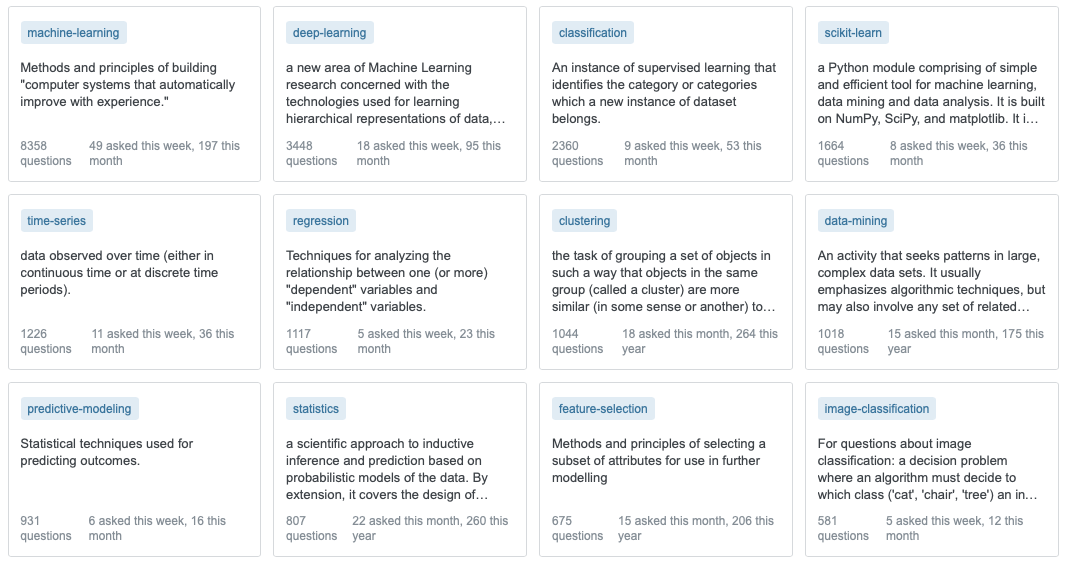

- Users — a list of users;
- Unanswered — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

**What information is available in each post?**

- Looking, just as an example, at this question, some of the information we see is:
    - For both questions and answers:
    - The posts's score;
    - The posts's title;
    - The posts's author;
- The posts's body;
    - For questions only:
    - How many users have it on their "
    - The last time the question as active;
    - How many times the question was viewed;
    - Related questions;
    - The question's tags;

## Getting the Data

To get the relevant data we run the following [query](https://data.stackexchange.com/datascience/query/new). 

    SELECT Id, CreationDate,
           Score, ViewCount, Tags,
           AnswerCount, FavoriteCount
      FROM posts
     WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
     
Here's what the first few rows look like:

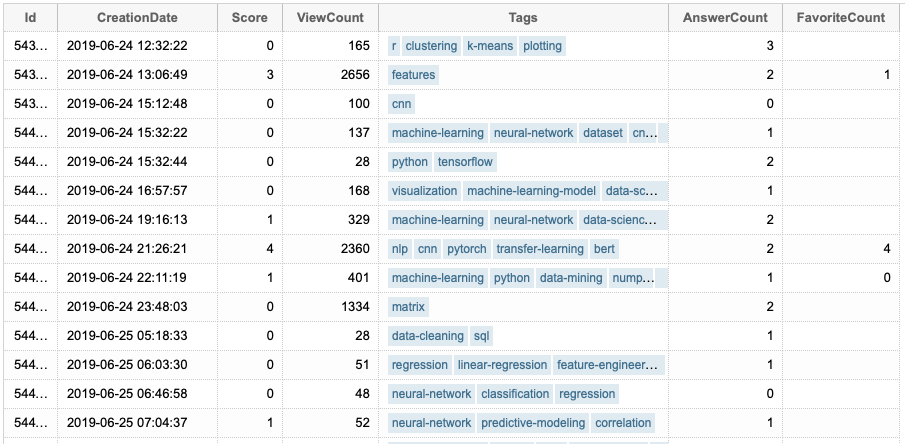

## Exploring the Data

We can read in the data while immediately making sure CreationDate will be stored as a datetime object:

In [1]:
# We import everything that we'll use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [3]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6913 entries, 0 to 6912
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6913 non-null   int64         
 1   CreationDate   6913 non-null   datetime64[ns]
 2   Score          6913 non-null   int64         
 3   ViewCount      6913 non-null   int64         
 4   Tags           6913 non-null   object        
 5   AnswerCount    6913 non-null   int64         
 6   FavoriteCount  1549 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 378.2+ KB


We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in questions["Tags"] are.

In [4]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

## Cleaning the Data

We will begin by fixing FavoriteCount.

In [5]:
questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

Now let's modify Tags to make it easier to work with.

In [6]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,54387,2019-06-24 12:32:22,0,165,<r><clustering><k-means><plotting>,3,0
1,54390,2019-06-24 13:06:49,3,2656,<features>,2,1
2,54398,2019-06-24 15:12:48,0,100,<cnn>,0,0
3,54401,2019-06-24 15:32:22,0,137,<machine-learning><neural-network><dataset><cn...,1,0
4,54402,2019-06-24 15:32:44,0,28,<python><tensorflow>,2,0


In [7]:
questions['Tags'] = questions['Tags'].str.replace('><', ',').str.strip('<>').str.split(',')
questions['Tags'].head()

0                   [r, clustering, k-means, plotting]
1                                           [features]
2                                                [cnn]
3    [machine-learning, neural-network, dataset, cn...
4                                 [python, tensorflow]
Name: Tags, dtype: object

In [8]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,54387,2019-06-24 12:32:22,0,165,"[r, clustering, k-means, plotting]",3,0
1,54390,2019-06-24 13:06:49,3,2656,[features],2,1
2,54398,2019-06-24 15:12:48,0,100,[cnn],0,0
3,54401,2019-06-24 15:32:22,0,137,"[machine-learning, neural-network, dataset, cn...",1,0
4,54402,2019-06-24 15:32:44,0,28,"[python, tensorflow]",2,0


## Most Used and Most Viewed

We'll beigin by counting how many times each tag was used. 

In [9]:
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1           

For improved aesthetics, let's transform tag_count in a dataframe.

In [10]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
r,198
clustering,236
k-means,76
plotting,26
features,22
cnn,382
machine-learning,2169
neural-network,832
dataset,259
convolution,75


Let's now sort this dataframe by Count and visualize the top 20 results.

In [11]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

,Count
feature-selection,176
statistics,176
r,198
predictive-modeling,213
clustering,236
dataset,259
regression,274
lstm,294
pandas,318
time-series,340


The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data.


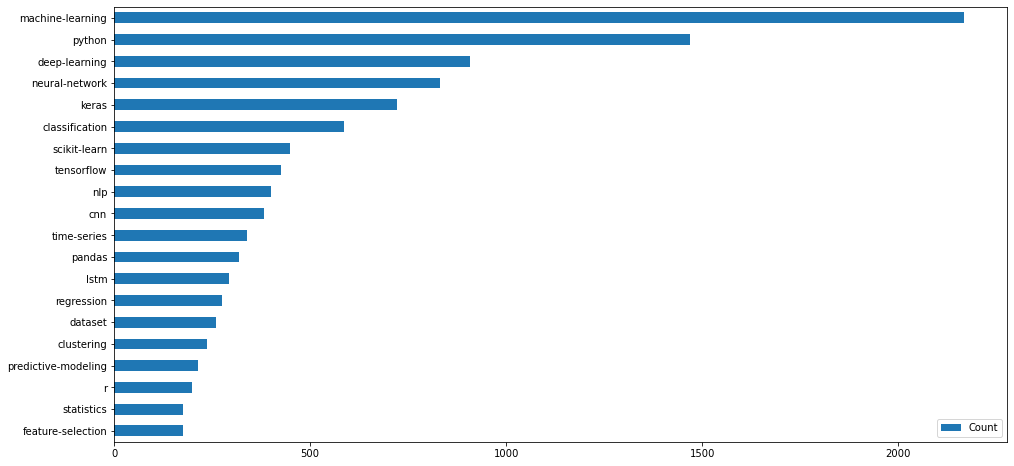

In [12]:
most_used.plot(kind="barh", figsize=(16,8))

Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

We'll use pandas's pandas.DataFrame.iterrows().

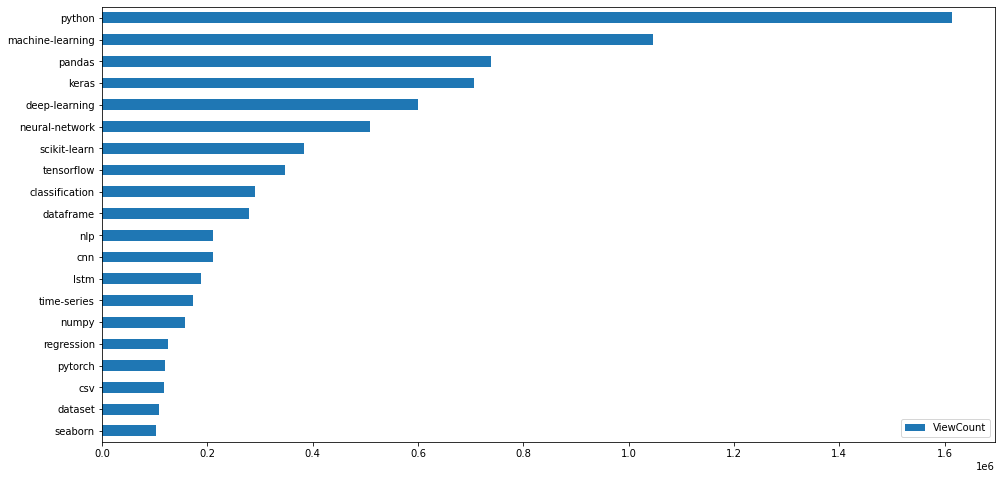

In [13]:
tag_view_count = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_view_count:
            tag_view_count[tag] += row['ViewCount']
        else:
            tag_view_count[tag] = row['ViewCount']
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)        

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

most_viewed.plot(kind="barh", figsize=(16,8))

Let's see them side by side. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f902df824f0>],
      dtype=object)

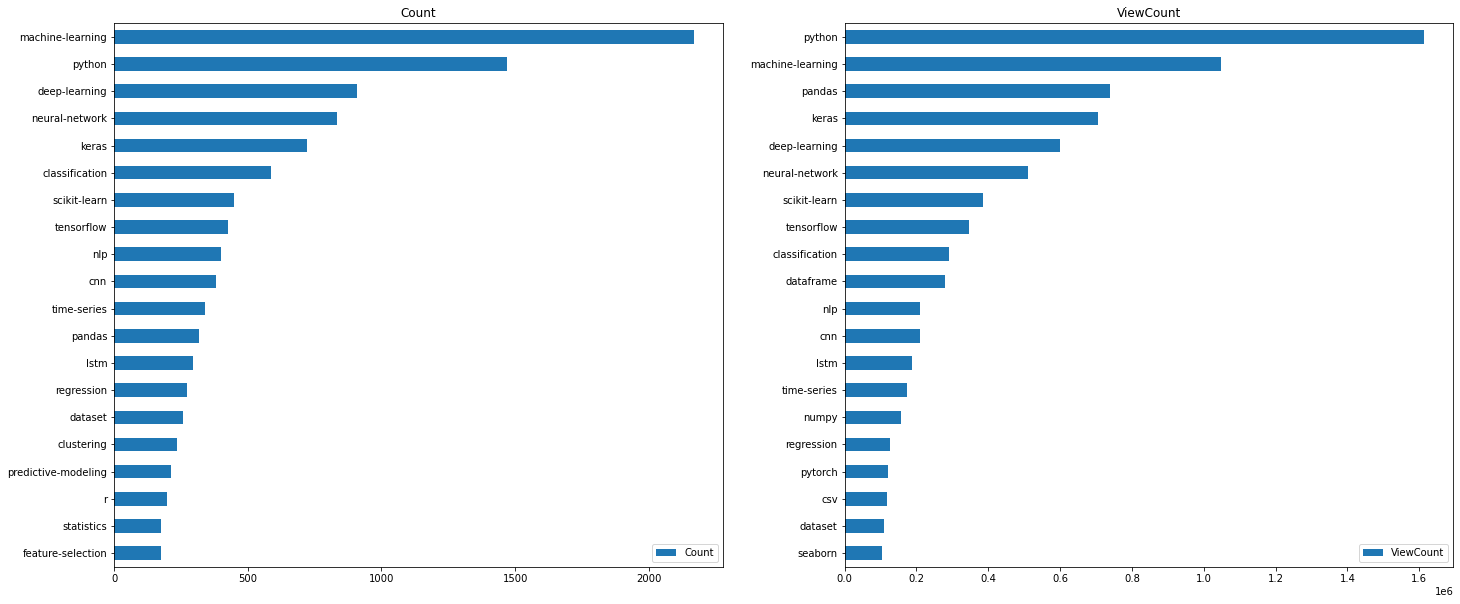

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

Machine learning, Python, Nueral Network, deep learning and Keras are the most tagged with Machine learning having a large number of tags. The same are also the most viewed but with Python having the most views. This might be because these tags are related, each and every time machine learning is tagged, deep learning is tagged.

From the DSSE Tag site (https://datascience.stackexchange.com/tags) there could be an explanation for the frequent use and views of Machine learning, Python, Nueral Network, deep learning and Keras tags. Machine Laerning involves building of automated applications to improve experience; while Nueral Network is one of the Machine Learning Methods and mimics the biological nuerons; Deep Learning is a new area of Machine learning concerned with the technologies used for learning hierarchical representations of data; Python is the preferred Data Science programming language wherals Kears is a minimalist, highly modular neural network library written in Python. All these tags have a connecting relationship and are easily used interchangeably thus the hugh frequency

### More analysis on Deep Learning

In this analysis we are going try and comfirm whether Deep Learning is here to stay. We obtained data from the DSSE using this querry:

SELECT Id, CreationDate, Tags FROM posts WHERE PostTypeId = 1;

In [15]:
all_answers = pd.read_csv("all_questions.csv", parse_dates = ["CreationDate"])

In [27]:
all_answers.tail()

,Id,CreationDate,Tags,DeepLearning
26233,75151,2020-05-31 03:44:37,"[python, deep-learning, keras, tensorflow, ima...",0
26234,75154,2020-05-31 05:42:53,"[evaluation, search]",0
26235,75156,2020-05-31 06:03:18,"[classification, scikit-learn, nlp, spacy, ml]",0
26236,75157,2020-05-31 06:31:21,"[neural-network, deep-learning, keras, tensorf...",1
26237,75161,2020-05-31 07:46:50,"[cross-validation, accuracy]",0


In [17]:
all_answers.isnull().sum()

Id              0
CreationDate    0
Tags            0
dtype: int64

In [18]:
all_answers["Tags"] = all_answers["Tags"].str.replace("^<|>$","")

In [19]:
all_answers["Tags"] = all_answers["Tags"].str.split("><")

In [20]:
all_answers["Tags"].sample(5)

12107                      [machine-learning, time-series]
22295    [machine-learning, feature-selection, image-cl...
1279                       [categorical-data, correlation]
17773            [machine-learning, python, nltk, ipython]
8380                      [feature-extraction, python-3.x]
Name: Tags, dtype: object

In [21]:
deep_learning = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

In [23]:
def deep_learner(tags):
    for tag in tags:
        if tag in deep_learning:
            return 1
        else:
            return 0

In [24]:
all_answers["DeepLearning"] = all_answers["Tags"].apply(deep_learner)

In [28]:
all_answers.head(3)

,Id,CreationDate,Tags,DeepLearning
0,5,2014-05-13 23:58:30,[machine-learning],0
1,7,2014-05-14 00:11:06,"[education, open-source]",0
2,14,2014-05-14 01:25:59,"[data-mining, definitions]",0


We will implement Quarterly time frame to study the behaviour of deep learning

In [29]:
def quarter(time):
    year = str(time.year)
    quarter = str(((time.month -1))//3 + 1)
    return year + "Q" + quarter

In [30]:
all_answers["Quarter"] = all_answers["CreationDate"].apply(quarter)

In [31]:
all_answers.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,5,2014-05-13 23:58:30,[machine-learning],0,2014Q2
1,7,2014-05-14 00:11:06,"[education, open-source]",0,2014Q2
2,14,2014-05-14 01:25:59,"[data-mining, definitions]",0,2014Q2
3,15,2014-05-14 01:41:23,[databases],0,2014Q2
4,16,2014-05-14 01:57:56,"[machine-learning, bigdata, libsvm]",0,2014Q2


### Questions per quarter

In [32]:
Questions_by_quarter = all_answers.groupby("Quarter").agg({"DeepLearning" : ['sum', 'size']})

In [33]:
Questions_by_quarter

DeepLearning      
                 sum  size
Quarter                   
2014Q2             3   157
2014Q3             4   188
2014Q4             4   214
2015Q1             5   189
2015Q2             6   284
2015Q3            13   310
2015Q4            19   381
2016Q1            38   511
2016Q2            45   515
2016Q3            70   581
2016Q4            77   523
2017Q1           105   691
2017Q2           102   638
2017Q3           115   711
2017Q4           143   889
2018Q1           213  1208
2018Q2           259  1430
2018Q3           319  1465
2018Q4           256  1274
2019Q1           360  1739
2019Q2           360  1806
2019Q3           360  1749
2019Q4           311  1619
2020Q1           397  2049
2020Q2           505  2283
2020Q3           370  1767
2020Q4           237  1067

In [34]:
Questions_by_quarter.columns = ["Deep_Learning", "Total_Questions"]

In [35]:
Questions_by_quarter["Deep_Learning_Percent"] = round((Questions_by_quarter["Deep_Learning"]/Questions_by_quarter["Total_Questions"])*100, 2)

In [36]:
Questions_by_quarter

,Deep_Learning,Total_Questions,Deep_Learning_Percent
Quarter,,,
2014Q2,3,157,1.91
2014Q3,4,188,2.13
2014Q4,4,214,1.87
2015Q1,5,189,2.65
2015Q2,6,284,2.11
2015Q3,13,310,4.19
2015Q4,19,381,4.99
2016Q1,38,511,7.44
2016Q2,45,515,8.74


The questions concerning Deep Learning have kept increasing over the quarters which implies that it is here to stay.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f902e06e2b0>],
      dtype=object)

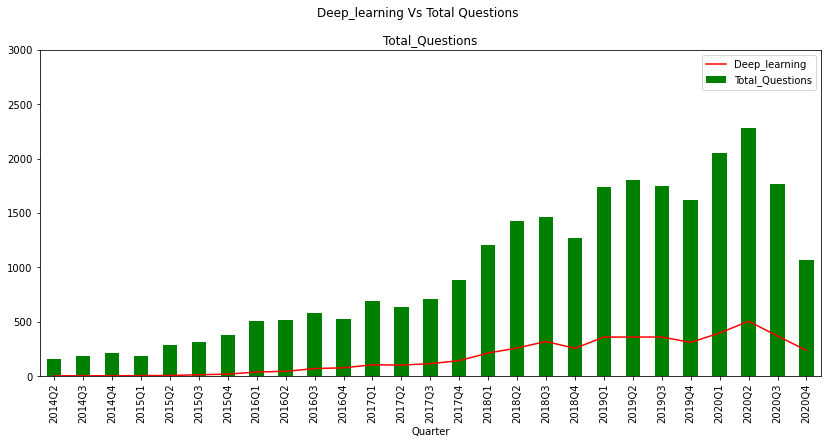

In [38]:
fig, axes = plt.subplots()
fig.set_size_inches((14, 6))
plt.ylim(0, 3000)
Questions_by_quarter["Deep_Learning"].plot(kind="line", color='red', subplots=True, label="Deep_learning", legend=True, title = "Deep_learning Vs Total Questions")
Questions_by_quarter["Total_Questions"].plot(kind="bar", color='green', subplots=True, label="Total_Questions", legend=True)

From the chart, Deep Learning qustions have been growing compared to the rest of the other data science questions. They contribute 20% towards the total questions and they might have taken a low in the last two quarters but I believe they will rise inpopularity in 2020.